In [56]:
#%pip install torch torchvision matplotlib numpy lgbt scikit-learn ipywidgets

In [57]:
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.manifold import TSNE
import ipywidgets as widgets
from IPython.display import display

In [58]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def show_images(images, title):
    images = images.cpu().detach().numpy()
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [59]:
def train_ae(model, train_loader, test_loader, epochs=20):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                outputs = model(data)
                loss = criterion(outputs, data)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
    
    return model

In [60]:
class FullyConnectedAE(nn.Module):
    def __init__(self):
        super(FullyConnectedAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()  # to probability
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # flatten
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)  # restore shape

Epoch 1/20, Train Loss: 0.0451, Test Loss: 0.0270
Epoch 2/20, Train Loss: 0.0244, Test Loss: 0.0228
Epoch 3/20, Train Loss: 0.0217, Test Loss: 0.0212
Epoch 4/20, Train Loss: 0.0200, Test Loss: 0.0196
Epoch 5/20, Train Loss: 0.0189, Test Loss: 0.0187
Epoch 6/20, Train Loss: 0.0181, Test Loss: 0.0180
Epoch 7/20, Train Loss: 0.0174, Test Loss: 0.0170
Epoch 8/20, Train Loss: 0.0166, Test Loss: 0.0164
Epoch 9/20, Train Loss: 0.0159, Test Loss: 0.0159
Epoch 10/20, Train Loss: 0.0153, Test Loss: 0.0153
Epoch 11/20, Train Loss: 0.0148, Test Loss: 0.0146
Epoch 12/20, Train Loss: 0.0143, Test Loss: 0.0146
Epoch 13/20, Train Loss: 0.0140, Test Loss: 0.0142
Epoch 14/20, Train Loss: 0.0137, Test Loss: 0.0137
Epoch 15/20, Train Loss: 0.0134, Test Loss: 0.0135
Epoch 16/20, Train Loss: 0.0132, Test Loss: 0.0133
Epoch 17/20, Train Loss: 0.0129, Test Loss: 0.0132
Epoch 18/20, Train Loss: 0.0127, Test Loss: 0.0129
Epoch 19/20, Train Loss: 0.0126, Test Loss: 0.0127
Epoch 20/20, Train Loss: 0.0124, Test Lo

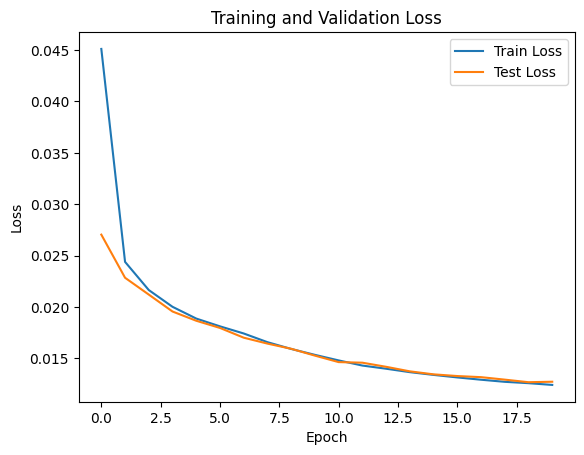

In [61]:
fc_ae = FullyConnectedAE()
fc_ae = train_ae(fc_ae, train_loader, test_loader)

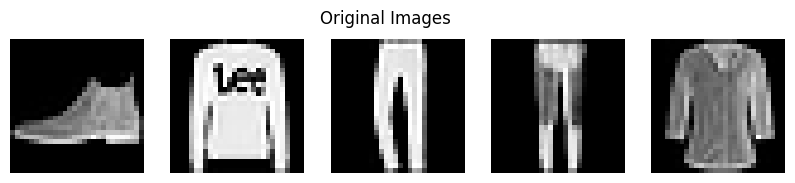

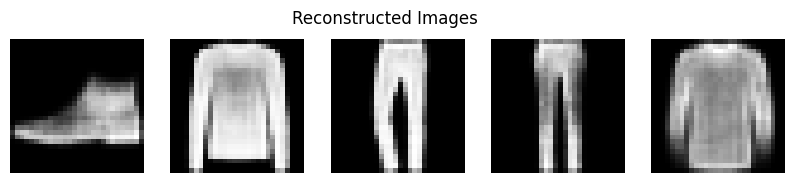

In [62]:
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    reconstructed = fc_ae(test_images)
    
show_images(test_images, 'Original Images')
show_images(reconstructed, 'Reconstructed Images')

In [71]:
torch.save(fc_ae, 'fc_autoencoder.pth')

In [63]:
def get_latent_representations(model, dataloader):
    model.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for data, label in dataloader:
            if isinstance(model, FullyConnectedAE):
                data = data.view(-1, 28*28)
                latent = model.encoder(data)
            else: 
                latent = model.encoder(data)
                latent = latent.view(latent.size(0), -1)
            latent_vectors.append(latent)
            labels.append(label)
    return torch.cat(latent_vectors), torch.cat(labels)

/tmp/ipykernel_33285/2825955010.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


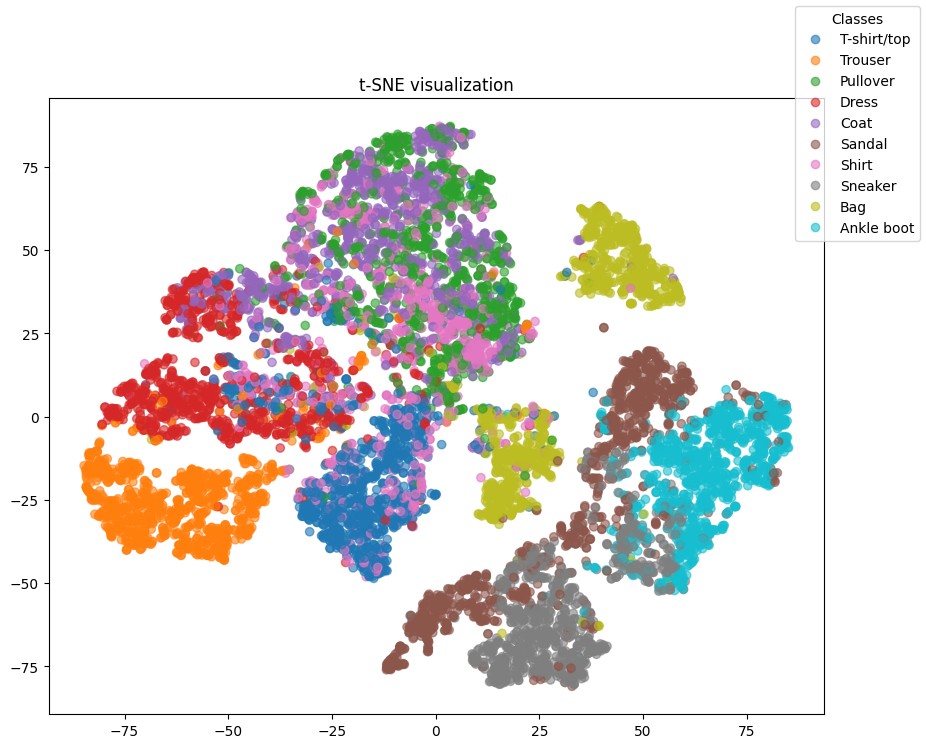

In [64]:
latent, labels = get_latent_representations(fc_ae, test_loader)

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent.cpu().numpy())

fig = plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x=latent_2d[:, 0], 
    y=latent_2d[:, 1],
    c=labels.cpu().numpy(),  
    cmap='tab10',
    alpha=0.6
)
fig.legend(
    handles=scatter.legend_elements()[0],
    labels=classes,
    title="Classes"
)

plt.title('t-SNE visualization')
fig.show()

In [65]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 32x7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                     # 64x1x1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),              # 32x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # 1x28x28
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/20, Train Loss: 0.0361, Test Loss: 0.0167
Epoch 2/20, Train Loss: 0.0142, Test Loss: 0.0125
Epoch 3/20, Train Loss: 0.0113, Test Loss: 0.0105
Epoch 4/20, Train Loss: 0.0098, Test Loss: 0.0095
Epoch 5/20, Train Loss: 0.0089, Test Loss: 0.0088
Epoch 6/20, Train Loss: 0.0083, Test Loss: 0.0082
Epoch 7/20, Train Loss: 0.0078, Test Loss: 0.0078
Epoch 8/20, Train Loss: 0.0075, Test Loss: 0.0075
Epoch 9/20, Train Loss: 0.0072, Test Loss: 0.0073
Epoch 10/20, Train Loss: 0.0070, Test Loss: 0.0071
Epoch 11/20, Train Loss: 0.0068, Test Loss: 0.0069
Epoch 12/20, Train Loss: 0.0067, Test Loss: 0.0068
Epoch 13/20, Train Loss: 0.0066, Test Loss: 0.0067
Epoch 14/20, Train Loss: 0.0065, Test Loss: 0.0066
Epoch 15/20, Train Loss: 0.0064, Test Loss: 0.0065
Epoch 16/20, Train Loss: 0.0063, Test Loss: 0.0065
Epoch 17/20, Train Loss: 0.0062, Test Loss: 0.0064
Epoch 18/20, Train Loss: 0.0061, Test Loss: 0.0063
Epoch 19/20, Train Loss: 0.0061, Test Loss: 0.0063
Epoch 20/20, Train Loss: 0.0060, Test Lo

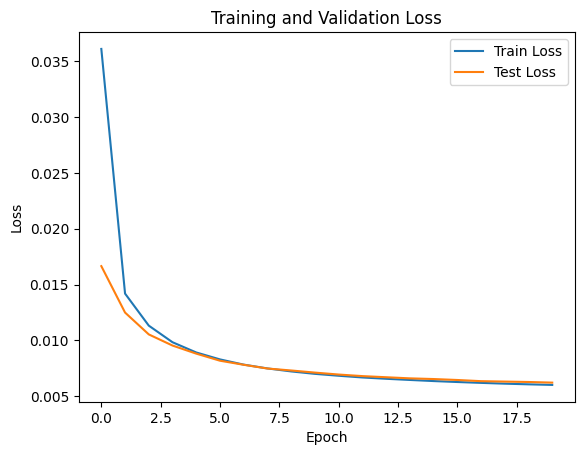

In [66]:
conv_ae = ConvAE()
conv_ae = train_ae(conv_ae, train_loader, test_loader)

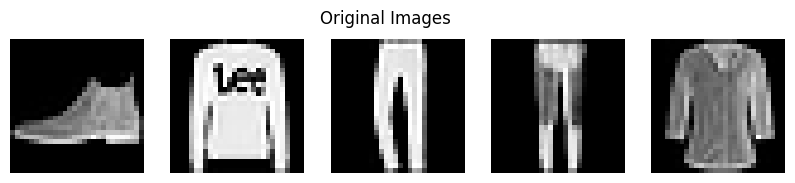

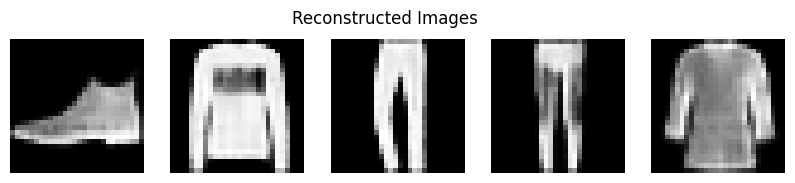

In [67]:
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    reconstructed = conv_ae(test_images)
    
show_images(test_images, 'Original Images')
show_images(reconstructed, 'Reconstructed Images')

In [72]:
torch.save(conv_ae, 'conv_autoencoder.pth')

/tmp/ipykernel_33285/1389893435.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


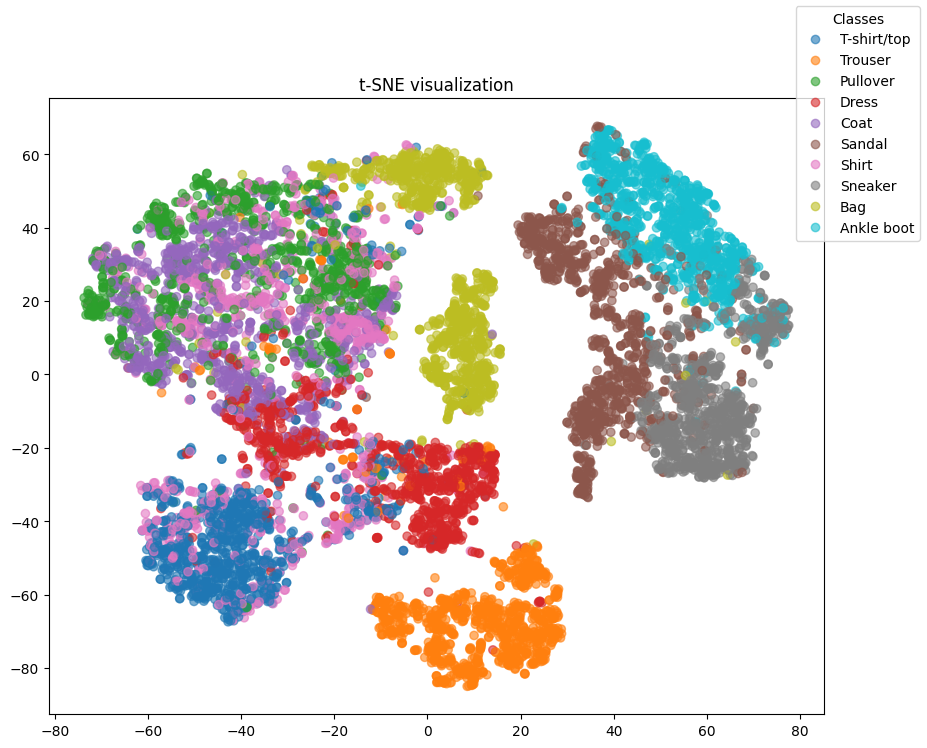

In [68]:
latent, labels = get_latent_representations(conv_ae, test_loader)

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent.cpu().numpy())

fig = plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x=latent_2d[:, 0], 
    y=latent_2d[:, 1],
    c=labels.cpu().numpy(),  
    cmap='tab10',
    alpha=0.6
)
fig.legend(
    handles=scatter.legend_elements()[0],
    labels=classes,
    title="Classes"
)

plt.title('t-SNE visualization')
fig.show()

In [69]:
def interactive_decoder(model, latent_dim=10):
    sliders = []
    for i in range(latent_dim):
        sliders.append(widgets.FloatSlider(
            value=0, min=-3, max=3, step=0.1,
            description=f'Dim {i}', continuous_update=True
        ))
    
    output = widgets.Output()
    
    def update_image(**kwargs):
        latent_vector = torch.tensor([list(kwargs.values())], dtype=torch.float32)
        with torch.no_grad():
            if latent_dim < model.decoder[0].in_features:
                zeros = torch.zeros(1, model.decoder[0].in_features - latent_dim)
                latent_vector = torch.cat([latent_vector, zeros], dim=1)
            decoded = model.decoder(latent_vector).view(1, 1, 28, 28)
        
        with output:
            output.clear_output(wait=True)
            plt.imshow(decoded[0][0].cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.show()
    
    ui = widgets.VBox(sliders)
    widgets.interactive(update_image, **{slider.description: slider for slider in sliders})
    display(ui, output)

In [ ]:
interactive_decoder(fc_ae, latent_dim=10)